# Описание задания

**Цель лабораторной работы:** изучение сложных способов подготовки выборки и подбора гиперпараметров на примере метода ближайших соседей.



# Задание

1.	Выберите набор данных (датасет) для решения задачи классификации или регресии.
2.	В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3.	С использованием метода train_test_split разделите выборку на обучающую и тестовую.
4.	Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. Оцените качество модели с помощью трех подходящих для задачи метрик.
5.	Постройте модель и оцените качество модели с использованием кросс-валидации. Проведите эксперименты с тремя различными стратегиями кросс-валидации.
6.	Произведите подбор гиперпараметра K с использованием GridSearchCV и кросс-валидации.
7.	Повторите пункт 4 для найденного оптимального значения гиперпараметра K. Сравните качество полученной модели с качеством модели, полученной в пункте 4.
8.	Постройте кривые обучения и валидации.






# Ход выполнения лабораторной работы

## Выбор датасета

В качестве исходных данных выбираем датасет о террористических атаках. Он содержит около 180 тысячи записей, а также имеет разные столбцы с категориальными данными. Такой датасет может подходить для обучения методом ближайших соседей.

В качестве задачи поставим определение вида атаки по остальным колонкам.

## Проверка и удаление пропусков

In [1]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from google.colab import files
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
os.listdir()
data = pd.read_csv('drive/My Drive/Files/globalterrorismdb_0718dist.csv',
                   sep=",", encoding="iso-8859-1")

In [4]:
total_count = data.shape[0]
num_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='float64' or dt=='int64'):
        num_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'
              .format(col, dt, temp_null_count, temp_perc))

Колонка latitude. Тип данных float64. Количество пустых значений 4556, 2.51%.
Колонка longitude. Тип данных float64. Количество пустых значений 4557, 2.51%.
Колонка specificity. Тип данных float64. Количество пустых значений 6, 0.0%.
Колонка doubtterr. Тип данных float64. Количество пустых значений 1, 0.0%.
Колонка alternative. Тип данных float64. Количество пустых значений 152680, 84.03%.
Колонка multiple. Тип данных float64. Количество пустых значений 1, 0.0%.
Колонка attacktype2. Тип данных float64. Количество пустых значений 175377, 96.52%.
Колонка attacktype3. Тип данных float64. Количество пустых значений 181263, 99.76%.
Колонка targsubtype1. Тип данных float64. Количество пустых значений 10373, 5.71%.
Колонка natlty1. Тип данных float64. Количество пустых значений 1559, 0.86%.
Колонка targtype2. Тип данных float64. Количество пустых значений 170547, 93.87%.
Колонка targsubtype2. Тип данных float64. Количество пустых значений 171006, 94.12%.
Колонка natlty2. Тип данных float64. К

Количество пустых колонок огромно, поэтому сначала удалим все столбцы, у которых количество заполненных значений менее 150000 (примерно 5/6 от всего датасета), а затем удалим строки с пустым значением.

In [5]:
# Удаление колонок, содержащих пустые значения
data_temp_1 = data.dropna(axis=1, how='any', thresh=150000)
(data.shape, data_temp_1.shape)

((181691, 135), (181691, 47))

In [6]:
data_new_1 = data_temp_1.dropna(axis=0, how='any')
(data_temp_1.shape, data_new_1.shape)

((181691, 47), (134042, 47))

In [7]:
data_new_1.head()

,eventid,iyear,imonth,iday,extended,country,country_txt,region,region_txt,provstate,...,weapsubtype1_txt,nkill,nwound,property,ishostkid,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY
5,197001010002,1970,1,1,0,217,United States,1,North America,Illinois,...,Unknown Gun Type,0.0,0.0,1,0.0,Hewitt Project,-9,-9,0,-9
6,197001020001,1970,1,2,0,218,Uruguay,3,South America,Montevideo,...,Automatic or Semi-Automatic Rifle,0.0,0.0,0,0.0,PGIS,0,0,0,0
7,197001020002,1970,1,2,0,217,United States,1,North America,California,...,Unknown Explosive Type,0.0,0.0,1,0.0,Hewitt Project,-9,-9,0,-9
8,197001020003,1970,1,2,0,217,United States,1,North America,Wisconsin,...,Molotov Cocktail/Petrol Bomb,0.0,0.0,1,0.0,Hewitt Project,0,0,0,0
9,197001030001,1970,1,3,0,217,United States,1,North America,Wisconsin,...,Gasoline or Alcohol,0.0,0.0,1,0.0,Hewitt Project,0,0,0,0


In [8]:
data2 = data_new_1.drop(["provstate", "eventid", "latitude", "longitude",
                 "dbsource", "INT_LOG", "INT_IDEO", "INT_MISC",
                 "INT_ANY", "individual", "weapsubtype1",
                 "weapsubtype1_txt", "property"], axis=1)
data2.shape

(134042, 34)

## train_test_split



In [0]:
from sklearn.model_selection import train_test_split
attacktype = data2["attacktype1"]
data3 = data2.drop(["attacktype1",
                    "vicinity", "crit2",
                    "crit3", "natlty1", 
                    "iday", "imonth", "iyear",
                    "extended"], axis=1)
for col in data3.columns:
  dt = str(data[col].dtype)
  if not (dt=='float64' or dt=='int64'):
    data3 = data3.drop([col], axis=1)
data_X_train, data_X_test, data_y_train, data_y_test = train_test_split(
    data3, attacktype, test_size=0.2, random_state=1)

In [10]:
data3.head()

,country,region,specificity,crit1,doubtterr,multiple,success,suicide,targtype1,targsubtype1,guncertain1,weaptype1,nkill,nwound,ishostkid
5,217,1,1.0,1,0.0,0.0,1,0,3,22.0,0.0,5,0.0,0.0,0.0
6,218,3,1.0,1,0.0,0.0,0,0,3,25.0,0.0,5,0.0,0.0,0.0
7,217,1,1.0,1,1.0,0.0,1,0,21,107.0,0.0,6,0.0,0.0,0.0
8,217,1,1.0,1,0.0,0.0,1,0,4,28.0,0.0,8,0.0,0.0,0.0
9,217,1,1.0,1,0.0,0.0,1,0,2,21.0,0.0,8,0.0,0.0,0.0


## Обучение для произвольного параметра K

In [11]:
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score

cl1_1 = KNeighborsClassifier(n_neighbors=20)
cl1_1.fit(data_X_train, data_y_train)
target1_0 = cl1_1.predict(data_X_train)
target1_1 = cl1_1.predict(data_X_test)
accuracy_score(data_y_train, target1_0), accuracy_score(data_y_test, target1_1)

(0.7833689256105862, 0.7622813234361595)

In [12]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(data_y_train, target1_0), balanced_accuracy_score(data_y_test, target1_1)

(0.39558911898277416, 0.3628183402576897)

In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix(data_y_train, target1_0)

array([[ 6992,  2378,  2708,     0,    11,    33,    76,     4,     0],
       [ 1970, 18830,  6246,     3,    31,   103,   270,    10,     0],
       [ 1009,  2761, 54380,     1,    16,    21,   111,     0,     0],
       [   11,    77,   142,    20,     0,    13,    13,     0,     0],
       [   28,   112,   222,     0,   131,    18,    16,     0,     0],
       [  379,  1059,   900,     3,    16,  1000,    77,     3,     0],
       [   96,   328,  1562,     4,     4,    11,  2561,     4,     0],
       [   23,    81,   187,     2,     0,    13,    58,    89,     0],
       [    1,     3,     1,     0,     0,     0,     1,     0,     0]])

In [14]:
confusion_matrix(data_y_test, target1_1)

array([[ 1648,   649,   724,     0,     1,    22,    18,     0,     0],
       [  565,  4460,  1648,     0,    10,    33,    75,     6,     0],
       [  295,   783, 13452,     0,     6,    11,    40,     0,     0],
       [    2,    15,    39,     0,     0,     7,     4,     0,     0],
       [    5,    16,    70,     0,    41,     4,     7,     0,     0],
       [  104,   310,   243,     2,     3,   186,    29,     2,     0],
       [   29,    87,   402,     0,     3,     6,   638,     2,     0],
       [    5,    28,    42,     0,     0,     6,    14,    11,     0],
       [    0,     0,     1,     0,     0,     0,     0,     0,     0]])

Видно, что метод ближайших соседей с гиперпараметром 20 подходит для определения выходного значения, однако нет уверенности в том, что это будет являться лучшим гиперпараметром.

## Построение модели и оценка с помощью кросс-валидации

In [0]:
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate

scoring = {'precision': 'precision_weighted', 
           'recall': 'recall_weighted',
           'f1': 'f1_weighted'}

scores1 = cross_validate(KNeighborsClassifier(n_neighbors=2), 
                        data3, attacktype, scoring=scoring, 
                        cv=KFold(n_splits=3), return_train_score=True)
scores1

In [0]:
scores2 = cross_validate(KNeighborsClassifier(n_neighbors=2), 
                        data3, attacktype, scoring=scoring, 
                        cv=StratifiedKFold(n_splits=3), return_train_score=True)
scores2

In [0]:
scores3 = cross_validate(KNeighborsClassifier(n_neighbors=2), 
                        data3, attacktype, scoring=scoring, 
                        cv=ShuffleSplit(n_splits=3, test_size=0.25), return_train_score=True)
scores3

In [18]:
print("%s, %s, %s" % (np.mean(scores1["test_precision"]),
                      np.mean(scores2["test_precision"]), 
                      np.mean(scores3["test_precision"])))

0.6938141352174684, 0.688623355258902, 0.7903253108335272


## Подбор гиперпараметра K с использованием GridSearchCV и кросс-валидации

In [19]:
n_range = np.array(range(2,33,4))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([ 2,  6, 10, 14, 18, 22, 26, 30])}]

In [20]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5,
                      scoring='accuracy')
clf_gs.fit(data_X_train, data_y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_neighbors': array([ 2,  6, 10, 14, 18, 22, 26, 30])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [21]:
clf_gs.best_params_

{'n_neighbors': 6}

Лучшее распознавание получается при гиперпараметре K = 6

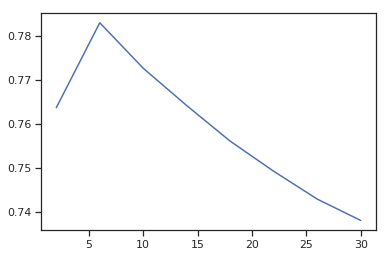

In [22]:
plt.plot(n_range, clf_gs.cv_results_['mean_test_score'])

## Сравнение модели с произвольным и лучшим параметром K

In [0]:
cl1_2 = KNeighborsClassifier(n_neighbors=6)
cl1_2.fit(data_X_train, data_y_train)
target2_0 = cl1_2.predict(data_X_train)
target2_1 = cl1_2.predict(data_X_test)

In [24]:
acc11 = accuracy_score(data_y_train, target1_0)
acc12 = accuracy_score(data_y_test, target1_1)
acc11, acc12

(0.7833689256105862, 0.7622813234361595)

In [25]:
acc21 = accuracy_score(data_y_train, target2_0)
acc22 = accuracy_score(data_y_test, target2_1)
acc21, acc22

(0.8407299991607061, 0.7903316050580029)

In [26]:
print("Увеличилось на %.4f и %.4f процентов." % (100*(acc21-acc11)/acc21, 100*(acc22-acc12)/acc22))

Увеличилось на 6.8228 и 3.5492 процентов.


Как видно, подбор гиперпараметра немного улучшил результат

## Кривые обучения и валидации

In [0]:
from sklearn.model_selection import learning_curve, validation_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
  
def plot_validation_curve(estimator, title, X, y, 
                          param_name, param_range, cv, 
                          scoring="accuracy"):                                        
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt  

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

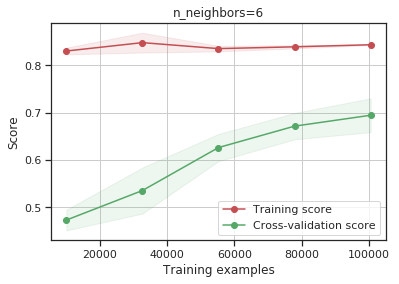

In [31]:
plot_learning_curve(KNeighborsClassifier(n_neighbors=6), 'n_neighbors=6', 
                    data3, attacktype, cv=4)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

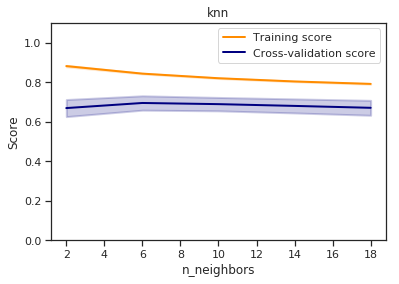

In [33]:
n_range2 = np.array(range(2,20,4))

plot_validation_curve(KNeighborsClassifier(), 'knn', 
                      data3, attacktype, 
                      param_name='n_neighbors', param_range=n_range2, 
                      cv=4, scoring="accuracy")